# **Обучение SRGAN**

## Импорт инструментов

In [1]:
import os
import math
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize
from torchvision.models.vgg import vgg16
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

torch.autograd.set_detect_anomaly(True)

## Набор данных и загрузчик

In [2]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


class TrainDatasetFromFolder(Dataset):
    def __init__(self, image_filenames, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = image_filenames
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [3]:
div2k_train_path = '/kaggle/input/div2k/DIV2K_train_HR/DIV2K_train_HR'
flickr2k_path = '/kaggle/input/flickr2k/Flickr2K'
div2k_valid_path = '/kaggle/input/div2k/DIV2K_valid_HR/DIV2K_valid_HR'

# Собираем пути к изображениям в едином списке
dirs_paths = [div2k_train_path, flickr2k_path, div2k_valid_path]
imgs_paths = []
for dir_path in dirs_paths:
    imgs_paths.extend(
        [os.path.join(dir_path, x) for x in os.listdir(dir_path) if is_image_file(x)]
    )
    
# Перемешиваем список
random.shuffle(imgs_paths)

# Вычисляем индекс разделения на выборок с 15% на валидацию
train_size = int(len(imgs_paths) * 0.85)

# Разделяем список на две выборки
train_paths = imgs_paths[:train_size]
val_paths = imgs_paths[train_size:]

UPSCALE_FACTOR = 4
CROP_SIZE = 256
BATCH_SIZE = 16

train_data = TrainDatasetFromFolder(
    train_paths, crop_size=CROP_SIZE,
    upscale_factor=UPSCALE_FACTOR
    )

valid_data = TrainDatasetFromFolder(
    val_paths, crop_size=CROP_SIZE,
    upscale_factor=UPSCALE_FACTOR
    )

trainloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True,
    pin_memory=True
)

valloader = DataLoader(
    dataset=valid_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False,
    pin_memory=True
)

print('Len of train dataset:', len(train_data))
print('Len of valid dataset:', len(valid_data))
print('Num of packages in the train loader:', len(trainloader))
print('Num of packages in the valid loader:', len(valloader))

Len of train dataset: 3017
Len of valid dataset: 533
Num of packages in the train loader: 189
Num of packages in the valid loader: 34


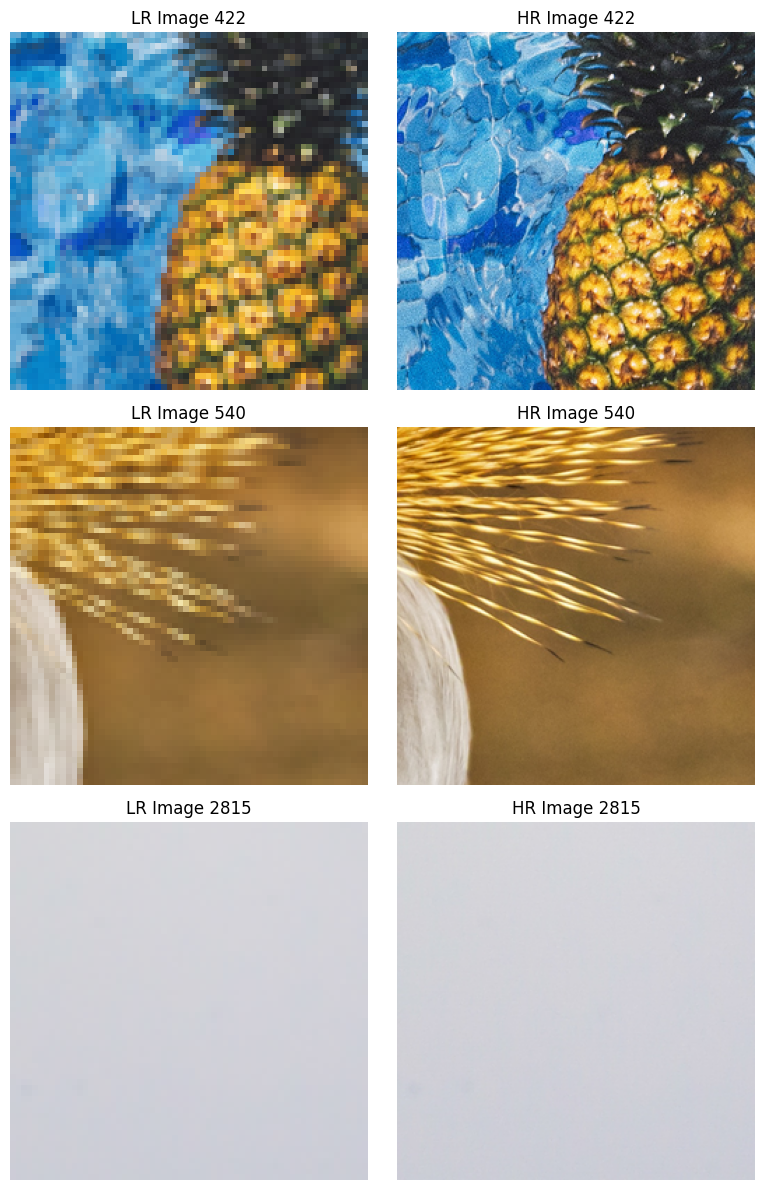

In [4]:
# Функция для визуализации двух случайных изображений
def visualize_random_images(dataset):
    # Получаем случайные индексы
    indices = random.sample(range(len(dataset)), 3)
    
    # Получаем изображения по индексам
    images = [dataset[i] for i in indices]
    
    # Настройка графика
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))
    
    for i, (lr_image, hr_image) in enumerate(images):
        # Преобразуем тензоры в numpy массивы для визуализации
        lr_image = lr_image.permute(1, 2, 0).numpy()  # (height, width, channels)
        hr_image = hr_image.permute(1, 2, 0).numpy()
        
        # Визуализация LR изображения
        axes[i, 0].imshow(lr_image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('LR Image {}'.format(indices[i]))

        # Визуализация HR изображения
        axes[i, 1].imshow(hr_image)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('HR Image {}'.format(indices[i]))

    plt.tight_layout()
    plt.show()

# Вызов функции визуализации
visualize_random_images(train_data)

## Архитектуры


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
    
        return x + residual
    
    
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBlock, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1
            )
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        
        return x

Имплементируем слои как в [статье на arxiv](https://arxiv.org/abs/1609.04802).

In [6]:
class Generator(nn.Module):
    def __init__(self, scale_factor):
        super(Generator, self).__init__()
        upsample_block_num = int(math.log(scale_factor, 2))

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)
        
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)
        
        return (torch.tanh(block8) + 1) / 2
        

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )
        
    def forward(self, x):
        batch_size=x.size()[0]
        
        return torch.sigmoid(self.net(x).view(batch_size))

## Лосс функции

In [8]:
class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight=tv_loss_weight
        
    def forward(self, x):
        batch_size=x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]

        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])

        h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
        w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size
    
    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]
    

class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(weights='IMAGENET1K_V1')
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()
        
    def forward(self, out_labels, out_images, target_images):
        adversial_loss = torch.mean(1 - out_labels)
        perception_loss = self.mse_loss(out_images, target_images)
        image_loss = self.mse_loss(out_images, target_images)
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss

## Инициализация

In [9]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()
generator_criterion = GeneratorLoss()

generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 178MB/s]  


## Обучение

In [10]:
def trainer(netG, netD, trainloader, valloader, N_EPOCHS=150, N_ROUNDS=4):
    BEST_METRIC = -np.inf
    BEST_LOSS = np.inf
    K = 0
    results = {
        "d_train_loss":[], "d_valid_loss":[], "g_train_loss":[], "g_valid_loss":[],
        "d_train_score": [], "d_valid_score":[], "g_train_score": [], "g_valid_score":[],
        "train_psnr": [], "valid_psnr":[], "train_ssim": [], "valid_ssim":[]
    }

    for epoch in range(1, N_EPOCHS + 1):
        is_early_stopping = False
        train_bar = tqdm(trainloader)
        running_results = {
            'd_loss': 0, "g_loss": 0, 'd_score': 0, 
            'g_score': 0, 'psnr': 0, 'ssim': 0
        }

        metrics = [PeakSignalNoiseRatio(), StructuralSimilarityIndexMeasure()]

        netG.train()
        netD.train()
        for data, target in train_bar:

            real_img = Variable(target).to(device)
            z = Variable(data).to(device)

            ## Update Discriminator 
            fake_img = netG(z)
            netD.zero_grad()
            real_out = netD(real_img).mean()
            fake_out = netD(fake_img).mean()
            d_loss = 1 - real_out + fake_out
            d_loss.backward(retain_graph=True)
            optimizerD.step()

            ## Now update Generator
            fake_img = netG(z)
            fake_out = netD(fake_img).mean()
            netG.zero_grad()
            g_loss = generator_criterion(fake_out, fake_img, real_img)
            g_loss.backward()

            optimizerG.step()

            running_results['g_loss'] += g_loss.item()
            running_results['d_loss'] += d_loss.item()
            running_results['d_score'] += real_out.item()
            running_results['g_score'] += fake_out.item()

            # Вычисляем метрики PSNR и SSIM
            psnr = metrics[0](real_img.detach().cpu() * 255, fake_img.detach().cpu() * 255).item()
            ssim = metrics[1](real_img.detach().cpu() * 255, fake_img.detach().cpu() * 255).item()
            running_results['psnr'] += psnr
            running_results['ssim'] += ssim

            train_bar.set_description(desc="T [%d/%d] Loss_D: %.4f | Loss_G: %.4f | D(x): %.4f | D(G(z)): %.4f | PSNR: %.4f | SSIM: %.4f" % (
                epoch, N_EPOCHS, d_loss.item(), g_loss.item(),
                real_out.item(), fake_out.item(), psnr, ssim
            ))
            
        # Сохраняем результаты тренировки
        results['d_train_loss'].append(running_results['d_loss'] / len(trainloader.dataset))
        results['g_train_loss'].append(running_results['g_loss'] / len(trainloader.dataset))
        results['d_train_score'].append(running_results['d_score'] / len(trainloader.dataset))
        results['g_train_score'].append(running_results['g_score'] / len(trainloader.dataset))
        results['train_psnr'].append(running_results['psnr'] / len(trainloader.dataset))
        results['train_ssim'].append(running_results['ssim'] / len(trainloader.dataset))

        # Валидация
        valid_bar = tqdm(valloader)
        netG.eval()
        netD.eval()
        val_running_results = {
            'val_d_loss': 0, 'val_g_loss': 0, 'val_d_score': 0, 
            'val_g_score': 0, 'val_psnr': 0, 'val_ssim': 0
        }
        
        with torch.no_grad():
            for val_data, val_target in valid_bar:
                val_real_img = Variable(val_target).to(device)
                val_z = Variable(val_data).to(device)

                val_fake_img = netG(val_z)
                real_out = netD(val_real_img).mean()
                fake_out = netD(val_fake_img).mean()
                val_d_loss = 1 - real_out + fake_out

                val_g_loss = generator_criterion(fake_out, val_fake_img, val_real_img)

                val_running_results['val_g_loss'] += val_g_loss.item()
                val_running_results['val_d_loss'] += val_d_loss.item()
                val_running_results['val_d_score'] += real_out.item()
                val_running_results['val_g_score'] += fake_out.item()

                # Вычисляем PSNR и SSIM для валидации
                val_psnr = metrics[0](val_real_img.detach().cpu() * 255, val_fake_img.detach().cpu() * 255).item()
                val_ssim = metrics[1](val_real_img.detach().cpu() * 255, val_fake_img.detach().cpu() * 255).item()
                val_running_results['val_psnr'] += val_psnr
                val_running_results['val_ssim'] += val_ssim
                
                valid_bar.set_description(desc="V [%d/%d] Loss_D: %.4f | Loss_G: %.4f | D(x): %.4f | D(G(z)): %.4f | PSNR: %.4f | SSIM: %.4f" % (
                    epoch, N_EPOCHS, val_d_loss.item(),val_g_loss.item(),
                    real_out.item(), fake_out.item(), val_psnr, val_ssim
                ))

        # Сохраняем результаты валидации
        results['d_valid_loss'].append(val_running_results['val_d_loss'] / len(valloader.dataset))
        results['g_valid_loss'].append(val_running_results['val_g_loss'] / len(valloader.dataset))
        results['d_valid_score'].append(val_running_results['val_d_score'] / len(valloader.dataset))
        results['g_valid_score'].append(val_running_results['val_g_score'] / len(valloader.dataset))
        results['valid_psnr'].append(val_running_results['val_psnr'] / len(valloader.dataset))
        results['valid_ssim'].append(val_running_results['val_ssim'] / len(valloader.dataset))

        # Логика ранней остановки и сохранения модели
        if results['g_valid_score'][-1] > BEST_METRIC:
            torch.save(netG.state_dict(), "best_G.pt")
            BEST_METRIC = results['g_valid_score'][-1]

        if BEST_LOSS > round(results['g_valid_loss'][-1], 6):
            BEST_LOSS = round(results['g_valid_loss'][-1], 6)
            K = 0
        elif K == N_ROUNDS:
            is_early_stopping = True
        else:
            K += 1
        
        torch.save(netG.state_dict(), "last_G.pt")
        
        if is_early_stopping:
            print(f"Early stopping at epoch {epoch}")
            break
        
        # Сброс метрик для следующей эпохи
        metrics[0].reset()
        metrics[1].reset()
        
    # Загрузим лучшие веса в модель
    netG.load_state_dict(torch.load("best_G.pt"))
        
    return results

In [11]:
results = trainer(netG, netD, trainloader, valloader, N_EPOCHS=150, N_ROUNDS=4)

T [1/150] Loss_D: 0.0035 | Loss_G: 0.0073 | D(x): 0.9981 | D(G(z)): 0.0015 | PSNR: 21.8917 | SSIM: 0.7086: 100%|██████████| 189/189 [05:50<00:00,  1.85s/it]
V [1/150] Loss_D: 1.0240 | Loss_G: 0.0067 | D(x): 0.0278 | D(G(z)): 0.0517 | PSNR: 22.2909 | SSIM: 0.7045: 100%|██████████| 34/34 [00:47<00:00,  1.38s/it]
T [2/150] Loss_D: 0.2569 | Loss_G: 0.0062 | D(x): 0.7431 | D(G(z)): 0.0013 | PSNR: 22.5798 | SSIM: 0.7051: 100%|██████████| 189/189 [05:54<00:00,  1.88s/it]
V [2/150] Loss_D: 1.0267 | Loss_G: 0.0048 | D(x): 0.0399 | D(G(z)): 0.0666 | PSNR: 24.1342 | SSIM: 0.8103: 100%|██████████| 34/34 [00:46<00:00,  1.38s/it]
T [3/150] Loss_D: 0.0004 | Loss_G: 0.0096 | D(x): 0.9997 | D(G(z)): 0.0001 | PSNR: 20.6177 | SSIM: 0.5480: 100%|██████████| 189/189 [05:47<00:00,  1.84s/it]
V [3/150] Loss_D: 1.0088 | Loss_G: 0.0041 | D(x): 0.0075 | D(G(z)): 0.0163 | PSNR: 24.8662 | SSIM: 0.7587: 100%|██████████| 34/34 [00:47<00:00,  1.38s/it]
T [4/150] Loss_D: 0.0002 | Loss_G: 0.0073 | D(x): 0.9998 | D(G(z

Early stopping at epoch 15



/tmp/ipykernel_36/2580778281.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load("best_G.pt"))


## Визуализация

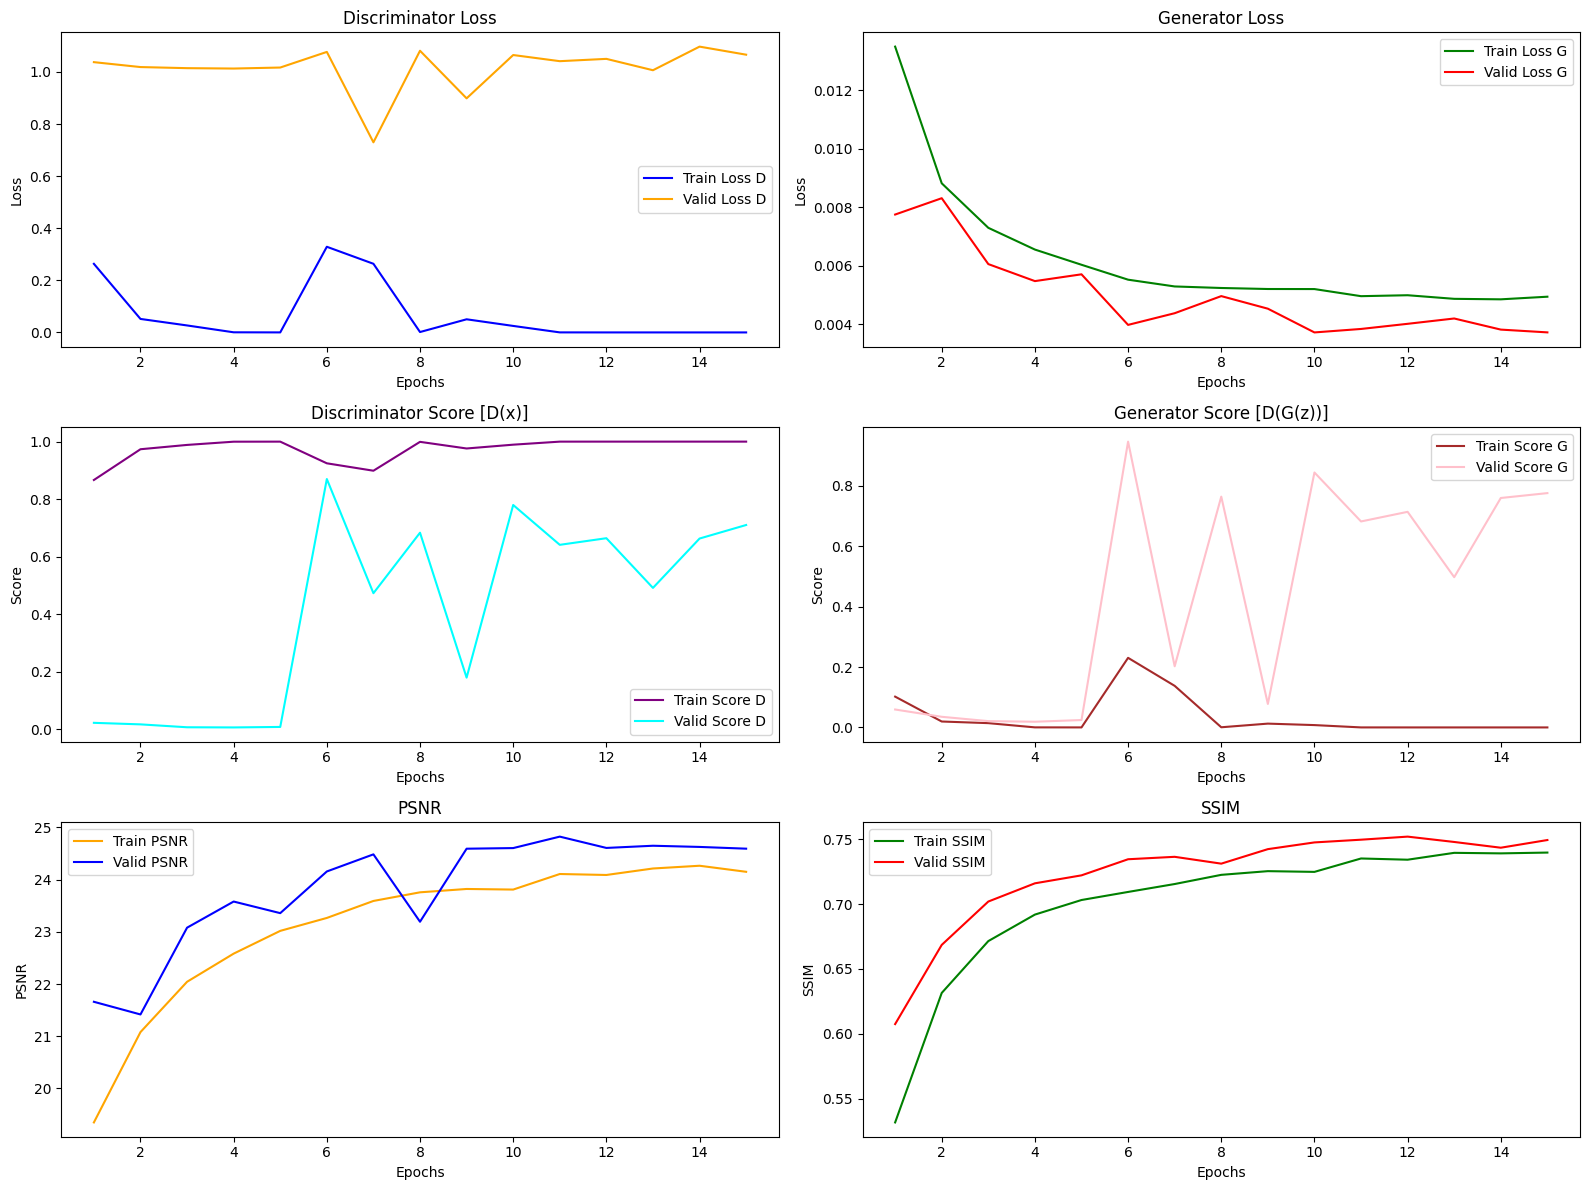

In [20]:
def visualize_results(results):
    epochs = range(1, len(results['d_train_loss']) + 1)

    # Визуализация потерь
    plt.figure(figsize=(16, 12))
    
    tr_k = len(trainloader.dataset) / len(trainloader)
    vl_k = len(valloader.dataset) / len(valloader)

    # Потери дискриминатора
    plt.subplot(3, 2, 1)
    plt.plot(epochs, [tr_k * el for el in results['d_train_loss']], label='Train Loss D', color='blue')
    plt.plot(epochs, [vl_k * el for el in results['d_valid_loss']], label='Valid Loss D', color='orange')
    plt.title('Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Потери генератора
    plt.subplot(3, 2, 2)
    plt.plot(epochs, [tr_k * el for el in results['g_train_loss']], label='Train Loss G', color='green')
    plt.plot(epochs, [vl_k * el for el in results['g_valid_loss']], label='Valid Loss G', color='red')
    plt.title('Generator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Оценка дискриминатора
    plt.subplot(3, 2, 3)
    plt.plot(epochs, [tr_k * el for el in results['d_train_score']], label='Train Score D', color='purple')
    plt.plot(epochs, [vl_k * el for el in results['d_valid_score']], label='Valid Score D', color='cyan')
    plt.title('Discriminator Score [D(x)]')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    # Оценка генератора
    plt.subplot(3, 2, 4)
    plt.plot(epochs, [tr_k * el for el in results['g_train_score']], label='Train Score G', color='brown')
    plt.plot(epochs, [vl_k * el for el in results['g_valid_score']], label='Valid Score G', color='pink')
    plt.title('Generator Score [D(G(z))]')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    # PSNR
    plt.subplot(3, 2, 5)
    plt.plot(epochs, [tr_k * el for el in results['train_psnr']], label='Train PSNR', color='orange')
    plt.plot(epochs, [vl_k * el for el in results['valid_psnr']], label='Valid PSNR', color='blue')
    plt.title('PSNR')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR')
    plt.legend()

    # SSIM
    plt.subplot(3, 2, 6)
    plt.plot(epochs, [tr_k * el for el in results['train_ssim']], label='Train SSIM', color='green')
    plt.plot(epochs, [vl_k * el for el in results['valid_ssim']], label='Valid SSIM', color='red')
    plt.title('SSIM')
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Вызовем функцию на наших результатах
visualize_results(results)

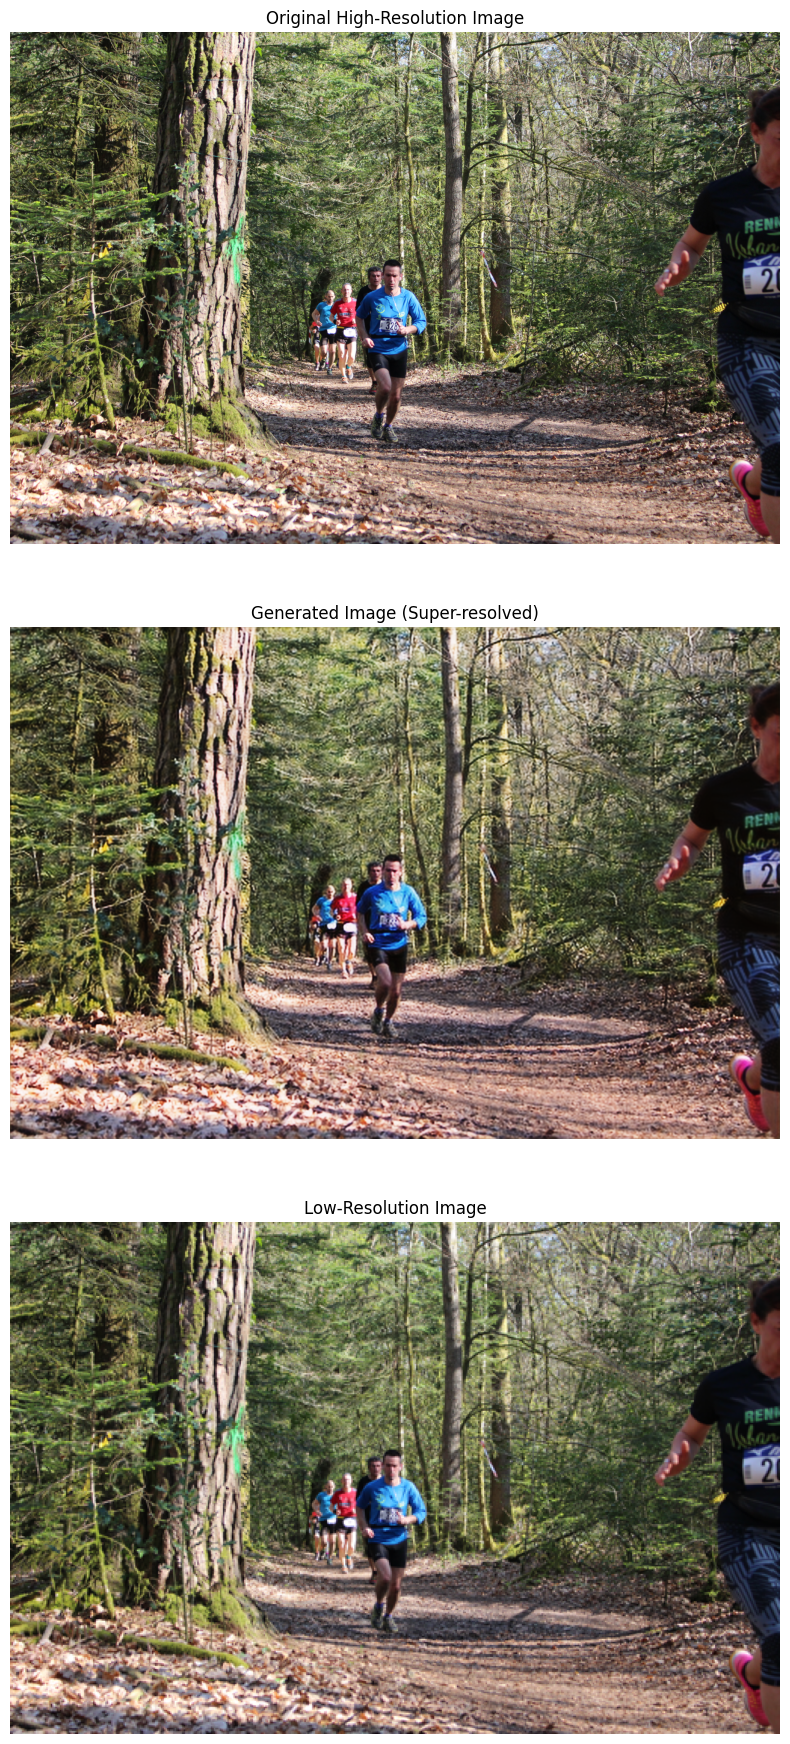

In [45]:
# Функция для загрузки изображения и изменения его размера
def load_and_preprocess_image(image_path, k=None):
    image = Image.open(image_path).convert('RGB')
    if k is not None:
        width, height = image.size
        image = image.resize((width // k, height // k), Image.BICUBIC)
    transform = ToTensor()
    return transform(image).unsqueeze(0)

# Функция для отображения изображений
def display_images(original, low_res, generated):
    plt.figure(figsize=(8, 18))

    # Оригинальное изображение
    plt.subplot(3, 1, 1)
    plt.title("Original High-Resolution Image")
    plt.imshow(original.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

    # Восстановленное изображение
    plt.subplot(3, 1, 2)
    plt.title("Generated Image (Super-resolved)")
    plt.imshow(generated.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    
    # Уменьшенное изображение
    plt.subplot(3, 1, 3)
    plt.title("Low-Resolution Image")
    plt.imshow(low_res.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Загрузка изображения
image_path = '/kaggle/input/flickr2k/Flickr2K/000001.png'
original_image = Image.open(image_path).convert('RGB')
original_width, original_height = original_image.size

# Уменьшение изображения
low_res_image = load_and_preprocess_image(image_path, k=UPSCALE_FACTOR)
low_res_image = low_res_image.to(device)

# Генерация изображения с помощью модели
netG.eval()
with torch.no_grad():
    generated_image = netG(low_res_image)

# Визуализация результатов
original_high_res_image = load_and_preprocess_image(image_path, k=None).squeeze(0)

# Отображение всех трех изображений по одному в три ряда
display_images(original_high_res_image, low_res_image.squeeze(0), generated_image.squeeze(0))